In [ ]:
# ========== System & File Management ==========
import os
import shutil
import glob
import time
import logging
from pathlib import Path

# ========== Data Science & Numerical Computing ==========
import pandas as pd
import numpy as np

# ========== Image Processing ==========
from PIL import Image
import cv2
from skimage import filters

# ========== Visualization ==========
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Cloning into 'VGTS'...
remote: Enumerating objects: 583, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 583 (delta 10), reused 0 (delta 0), pack-reused 541 (from 1)
Receiving objects: 100% (583/583), 139.71 MiB | 33.82 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Updating files: 100% (428/428), done.
/content/VGTS



===== Extraction Summary =====
Train query glyphs: 2130
Test query glyphs: 0
Support images: 253
Total images: 2383



<Figure size 1500x1000 with 0 Axes>

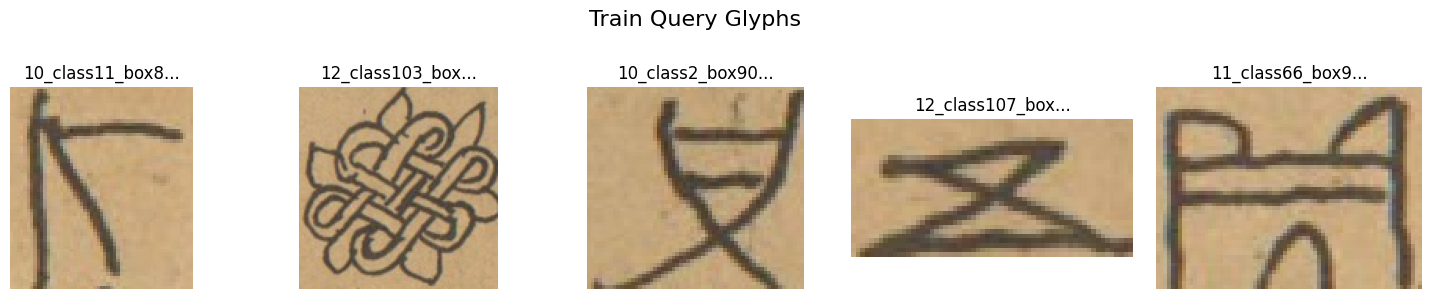

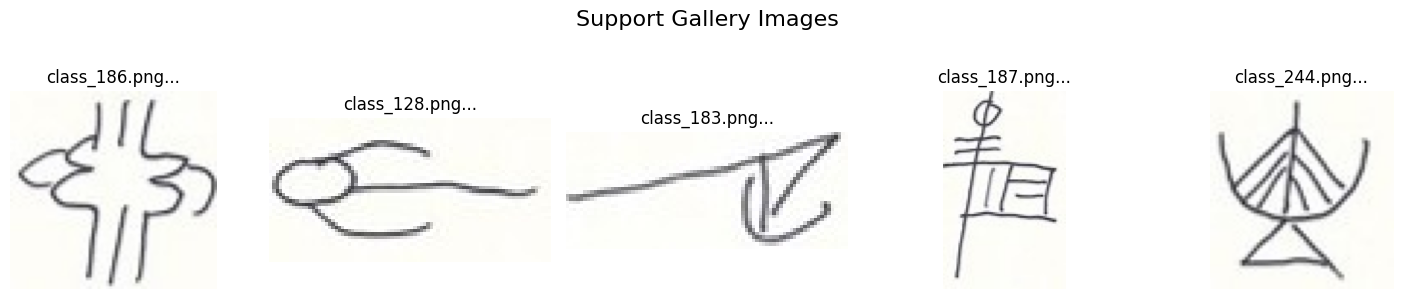


All extracted images are available in: /content/drive/MyDrive/script_analysis/real_naxi


In [ ]:
output_base_dir = '/content/drive/MyDrive/script_analysis/real_naxi'
!mkdir -p "{output_base_dir}"

!git clone https://github.com/infinite-hwb/VGTS.git
%cd VGTS

log_dir = f'{output_base_dir}/logs'
!mkdir -p "{log_dir}"

log_file = f'{log_dir}/extraction_log.txt'
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger()
logger.info("Starting DBH glyph extraction process")

def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        logger.info(f"Created directory: {directory}")

def extract_glyphs_from_csv(csv_path, image_dir, output_dir, set_name):
    logger.info(f"Processing {set_name} set")
    logger.info(f"- CSV: {csv_path}")
    logger.info(f"- Image directory: {image_dir}")

    glyphs_dir = os.path.join(output_dir, f"{set_name}_query_images")
    create_dir(glyphs_dir)

    try:
        df = pd.read_csv(csv_path)
        logger.info(f"- CSV contains {len(df)} annotations")

        unique_images = df['imageid'].unique()
        logger.info(f"- Found {len(unique_images)} unique images")

        glyph_count = 0
        metadata = []

        for image_id in unique_images:
            image_filename = f"{image_id}.jpg"
            image_path = os.path.join(image_dir, image_filename)

            if not os.path.exists(image_path):
                image_filename = f"{image_id}.png"
                image_path = os.path.join(image_dir, image_filename)
                if not os.path.exists(image_path):
                    logger.warning(f"Image {image_id} not found")
                    continue

            try:
                img = Image.open(image_path)
                img_width, img_height = img.size

                image_boxes = df[df['imageid'] == image_id]

                for _, box in image_boxes.iterrows():
                    lx = float(box['lx']) * img_width
                    rx = float(box['rx']) * img_width
                    ty = float(box['ty']) * img_height
                    by = float(box['by']) * img_height

                    x1, y1 = max(0, int(lx)), max(0, int(ty))
                    x2, y2 = min(img_width, int(rx)), min(img_height, int(by))

                    if x1 >= x2 or y1 >= y2:
                        logger.warning(f"Invalid box coordinates: {x1},{y1},{x2},{y2}")
                        continue

                    class_id = box['classid']
                    box_id = box['gtbboxid']

                    glyph = img.crop((x1, y1, x2, y2))

                    glyph_filename = f"{image_id}_class{class_id}_box{box_id}.png"
                    glyph_path = os.path.join(glyphs_dir, glyph_filename)
                    glyph.save(glyph_path)

                    metadata.append({
                        'filename': glyph_filename,
                        'image_id': image_id,
                        'class_id': class_id,
                        'box_id': box_id,
                        'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2,
                        'width': x2 - x1,
                        'height': y2 - y1,
                        'split': box.get('split', 'unknown')
                    })

                    glyph_count += 1
                    if glyph_count % 100 == 0:
                        logger.info(f"- Extracted {glyph_count} glyphs so far")

            except Exception as e:
                logger.error(f"Error processing image {image_id}: {str(e)}")

        metadata_dir = os.path.join(output_dir, "metadata")
        create_dir(metadata_dir)
        metadata_df = pd.DataFrame(metadata)
        metadata_path = os.path.join(metadata_dir, f"{set_name}_metadata.csv")
        metadata_df.to_csv(metadata_path, index=False)

        logger.info(f"Completed {set_name} set: {glyph_count} glyphs extracted")
        return glyph_count

    except Exception as e:
        logger.error(f"Error processing {set_name} set: {str(e)}")
        return 0

def extract_support_images(support_dir, output_dir):
    logger.info(f"Extracting support images from {support_dir}")

    support_output_dir = os.path.join(output_dir, "support_images")
    create_dir(support_output_dir)

    image_files = []
    for root, _, files in os.walk(support_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_files.append(os.path.join(root, file))

    logger.info(f"Found {len(image_files)} support images")

    count = 0
    for img_path in image_files:
        try:
            filename = os.path.basename(img_path)
            name, ext = os.path.splitext(filename)

            try:
                class_id = int(name)
                output_filename = f"class_{class_id}.png"
            except ValueError:
                output_filename = f"class_{name}.png"

            img = Image.open(img_path)
            output_path = os.path.join(support_output_dir, output_filename)
            img.save(output_path, format='PNG')
            count += 1

        except Exception as e:
            logger.error(f"Error processing support image {img_path}: {str(e)}")

    logger.info(f"Extracted {count} support images")
    return count

logger.info("Starting extraction process...")

dbh_dataset_path = os.path.join('DATA', 'DBH dataset')
query_train_path = os.path.join(dbh_dataset_path, 'query train')
query_test_path = os.path.join(dbh_dataset_path, 'query test')
support_gallery_path = os.path.join(dbh_dataset_path, 'support image gallery', 'images')

paths_exist = True
for path in [dbh_dataset_path, query_train_path, query_test_path, support_gallery_path]:
    if not os.path.exists(path):
        logger.error(f"Path not found: {path}")
        paths_exist = False

if paths_exist:
    train_csv = os.path.join(query_train_path, 'train.csv')
    if os.path.exists(train_csv):
        train_count = extract_glyphs_from_csv(train_csv, query_train_path, output_base_dir, "train")

    test_csv = os.path.join(query_test_path, 'test.csv')
    if not os.path.exists(test_csv):
        test_csv = os.path.join(query_test_path, 'train.csv')

    if os.path.exists(test_csv):
        test_count = extract_glyphs_from_csv(test_csv, query_test_path, output_base_dir, "test")

    if os.path.exists(support_gallery_path):
        support_count = extract_support_images(support_gallery_path, output_base_dir)

def count_files(directory):
    if not os.path.exists(directory):
        return 0
    return len([f for f in os.listdir(directory) if f.endswith(('.png', '.jpg', '.jpeg'))])

train_dir = os.path.join(output_base_dir, 'train_query_images')
test_dir = os.path.join(output_base_dir, 'test_query_images')
support_dir = os.path.join(output_base_dir, 'support_images')

train_count = count_files(train_dir)
test_count = count_files(test_dir)
support_count = count_files(support_dir)

logger.info("\n===== Extraction Summary =====")
logger.info(f"Train query glyphs: {train_count}")
logger.info(f"Test query glyphs: {test_count}")
logger.info(f"Support images: {support_count}")
logger.info(f"Total images: {train_count + test_count + support_count}")
logger.info("============================\n")

print("\n===== Extraction Summary =====")
print(f"Train query glyphs: {train_count}")
print(f"Test query glyphs: {test_count}")
print(f"Support images: {support_count}")
print(f"Total images: {train_count + test_count + support_count}")
print("============================\n")

plt.figure(figsize=(15, 10))

def display_samples(directory, title, num_samples=5):
    if not os.path.exists(directory) or len(os.listdir(directory)) == 0:
        return

    files = [f for f in os.listdir(directory) if f.endswith(('.png', '.jpg'))]
    if len(files) == 0:
        return

    samples = np.random.choice(files, min(num_samples, len(files)), replace=False)

    plt.figure(figsize=(15, 3))
    plt.suptitle(title, fontsize=16)

    for i, file in enumerate(samples):
        img_path = os.path.join(directory, file)
        plt.subplot(1, len(samples), i+1)
        img = Image.open(img_path)
        plt.imshow(np.array(img))
        plt.title(f"{file[:15]}...")
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

if train_count > 0:
    display_samples(train_dir, "Train Query Glyphs")

if test_count > 0:
    display_samples(test_dir, "Test Query Glyphs")

if support_count > 0:
    display_samples(support_dir, "Support Gallery Images")

print(f"\nAll extracted images are available in: {output_base_dir}")
logger.info("Extraction process completed.")

In [ ]:
source_dir = '/content/drive/MyDrive/script_analysis/real_naxi/train_query_images'
target_dir = '/content/drive/MyDrive/script_analysis/old_naxi'

os.makedirs(target_dir, exist_ok=True)

glyph_files = glob.glob(os.path.join(source_dir, '*.png'))

print(f"Found {len(glyph_files)} images in {source_dir}")
print(f"Processing and saving to {target_dir}...")

successful = 0
start_time = time.time()

for i, file_path in enumerate(glyph_files):
    try:
        filename = os.path.basename(file_path)

        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l_channel = lab[:, :, 0]
        threshold = filters.threshold_otsu(l_channel)

        binary = (l_channel < threshold).astype(np.uint8)
        binary_inverted = 1 - binary
        binary_display = binary_inverted * 255

        output_path = os.path.join(target_dir, filename)
        cv2.imwrite(output_path, binary_display)

        successful += 1

        if (i + 1) % 100 == 0:
            elapsed = time.time() - start_time
            progress = (i + 1) / len(glyph_files) * 100
            print(f"Progress: {i+1}/{len(glyph_files)} ({progress:.1f}%) - {elapsed:.1f} seconds elapsed")

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")

elapsed = time.time() - start_time
print(f"\nConversion complete!")
print(f"Successfully processed: {successful}/{len(glyph_files)} images")
print(f"Time taken: {elapsed:.2f} seconds")

converted_files = glob.glob(os.path.join(target_dir, '*.png'))
if converted_files:
    sample_files = random.sample(converted_files, min(5, len(converted_files)))

    plt.figure(figsize=(15, 3))
    for i, file_path in enumerate(sample_files):
        plt.subplot(1, 5, i+1)
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(img, cmap='gray')
        plt.title(os.path.basename(file_path)[:10] + "...")
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Sample Converted Images in old_naxi Directory")
    plt.subplots_adjust(top=0.85)
    plt.show()


Found 2130 images in /content/drive/MyDrive/script_analysis/real_naxi/train_query_images
Processing and saving to /content/drive/MyDrive/script_analysis/old_naxi...
Progress: 100/2130 (4.7%) - 35.3 seconds elapsed
Progress: 200/2130 (9.4%) - 36.9 seconds elapsed
Progress: 300/2130 (14.1%) - 38.4 seconds elapsed
Progress: 400/2130 (18.8%) - 39.9 seconds elapsed
Progress: 500/2130 (23.5%) - 41.6 seconds elapsed
Progress: 600/2130 (28.2%) - 43.2 seconds elapsed
Progress: 700/2130 (32.9%) - 44.8 seconds elapsed
Progress: 800/2130 (37.6%) - 46.7 seconds elapsed
Progress: 900/2130 (42.3%) - 49.3 seconds elapsed
Progress: 1000/2130 (46.9%) - 51.1 seconds elapsed
Progress: 1100/2130 (51.6%) - 52.8 seconds elapsed
Progress: 1200/2130 (56.3%) - 54.4 seconds elapsed
Progress: 1300/2130 (61.0%) - 56.2 seconds elapsed
Progress: 1400/2130 (65.7%) - 57.9 seconds elapsed
Progress: 1500/2130 (70.4%) - 59.6 seconds elapsed
Progress: 1600/2130 (75.1%) - 61.2 seconds elapsed
Progress: 1700/2130 (79.8%) - 

NameError: name 'random' is not defined